# Business Problem:

This coming straight from a Kaggle competition called : **Corporacion Favorita Grocery Sales Forecasting**.

The task is to predict sales in the stores of an Ecuadorian supermarket chain so that they can avoid overstocking, which would reduce waste and loss, and minimize understocking, which induces opportunity cost and lower customer satisfaction. For the sake of both the buisiness and the environment, better predictions are highly desirable. This increased efficiency could also result in higher profits for the stakeholders and/or a better pricepoint for customers, depending on the choices made by the chain.

The given data is a table with the following variables/features: date, store id, item id, sales volume, promotion.
Whereas store id and item id are integers, promotion is a boolean and sales volume is a float (integers for discrete items, float for volume/weight). We can see the data as N time series, one per (store, item) combination. Many of these time series are most likely correlated to each other and some sort of dimensional reduction will be most welcome here. 

The company also offers some other data sets, such as a list of stores with their location, a time series of daily transactions per store, a list of holidays and events, a list of products by category, and the price of oil, of which a good chunk of the ecuadorian economy is allegedly tied to. These are additional tools to simplify and/or enhance the predictions, and some other external data could also be used in this regard. We will most likely do so in future kernels.

The primary task is therefore forecasting. For the sake of simplicity, and as it is our first dip in time series, this kernel will focus on the **daily transactions data of a single store** instead of the sales data for all stores.

In [2]:
import warnings
warnings.filterwarnings("ignore")

# DATA MANIPULATION
import numpy as np # linear algebra
import random as rd # generating random numbers
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # manipulating date formats
from operator import add # elementwise addition

# VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
import seaborn # for prettier plots
#import folium # plotting data on interactive maps

# UNSUPERVISED LEARNING
from sklearn.cluster import AgglomerativeClustering as AggClust # Hierarchical Clustering
from scipy.cluster.hierarchy import ward,dendrogram # Hierarchical Clustering + Dendograms

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

In [9]:
# Reading daily transfers per store
sales=pd.read_csv('transactions.csv')

# Reading store list
stores=pd.read_csv('stores.csv')
stores.type=stores.type.astype('category')

# Adding information about the stores
sales=pd.merge(sales,stores,how='left')

# Reading the holiday and events schedule
holidays=pd.read_csv('holidays_events.csv')

# Formatting the dates properly
sales['date']=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
holidays['date']=holidays.date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))

# Isolating events that do not correspond to holidays
events=holidays.loc[holidays.type=='Event']
holidays=holidays.loc[holidays.type!='Event']

# Extracting year, week and day
sales['year'],sales['week'],sales['day']=list(zip(*sales.date.apply(lambda x: x.isocalendar())))

# Creating a categorical variable showing weekends
sales['dayoff']=[x in [6,7] for x in sales.day]

# Adjuusting this variable to show all holidays
for (d,t,l,n) in zip(holidays.date,holidays.type,holidays.locale,holidays.locale_name):
  if t!='Work Day':
    if l=='National':
      sales.loc[sales.date==d,'dayoff']=True
    elif l=='Regional':
      sales.loc[(sales.date==d)&(sales.state==n),'dayoff']=True
    else:
      sales.loc[(sales.date==d)&(sales.city==n),'dayoff']=True
  else:
    sales.loc[(sales.date==d),'dayoff']=False

# EDA

In [10]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 0 to 83487
Data columns (total 11 columns):
date            83488 non-null datetime64[ns]
store_nbr       83488 non-null int64
transactions    83488 non-null int64
city            83488 non-null object
state           83488 non-null object
type            83488 non-null category
cluster         83488 non-null int64
year            83488 non-null int32
week            83488 non-null int32
day             83488 non-null int32
dayoff          83488 non-null bool
dtypes: bool(1), category(1), datetime64[ns](1), int32(3), int64(3), object(2)
memory usage: 5.6+ MB


In [11]:
sales.head(20)

,date,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,2013,1,2,True
1,2013-01-02,1,2111,Quito,Pichincha,D,13,2013,1,3,False
2,2013-01-02,2,2358,Quito,Pichincha,D,13,2013,1,3,False
3,2013-01-02,3,3487,Quito,Pichincha,D,8,2013,1,3,False
4,2013-01-02,4,1922,Quito,Pichincha,D,9,2013,1,3,False
5,2013-01-02,5,1903,Santo Domingo,Santo Domingo de los Tsachilas,D,4,2013,1,3,False
6,2013-01-02,6,2143,Quito,Pichincha,D,13,2013,1,3,False
7,2013-01-02,7,1874,Quito,Pichincha,D,8,2013,1,3,False
8,2013-01-02,8,3250,Quito,Pichincha,D,8,2013,1,3,False
9,2013-01-02,9,2940,Quito,Pichincha,B,6,2013,1,3,False


### The Chosen One: **Store #47**
The chain established itselft in Quito in 1952 ([Wikipedia](https://es.wikipedia.org/wiki/Corporaci%C3%B3n_Favorita)), so let's pick a shop in Quito as a starting point, as the brand is well established there. Let us pick #47 and plot the corresponding transactions time series. 
With a well established store, we can predict that the time series will be almost stationary. High seasonality is expected too, as people consume more during celebration periods. Let's see what we get:

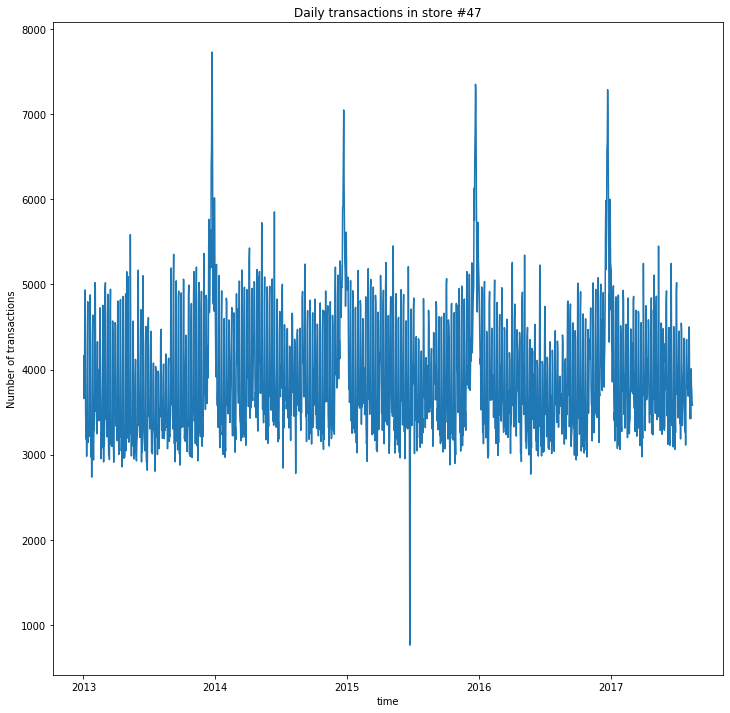

In [19]:
ts=sales.loc[sales['store_nbr']==47,['date','transactions']].set_index('date')
ts=ts.transactions.astype('float')
plt.figure(figsize=(12,12))
plt.title('Daily transactions in store #47')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

Interesting huge plunge between 2015 and 2016.

###  Seasonality and Outliers 
We can easily identify a peak around Christmas, a very low volume day mid 2015 and a fairly stable behavior in between. The surge in volume around Christmas was expected, but what happened mid 2015? As it turns out it corresponds to a giant national protest in Ecuador, which will most likely impact other stores as well. [Wikipedia](https://en.wikipedia.org/wiki/2015_Ecuadorian_protests#24_June)

  We can also see that outside of this holiday period, the transactions have quite a lot of variance, the volume oscillating between 3000 and 5000. Let's check the rolling mean and standard deviation with a window of a month::

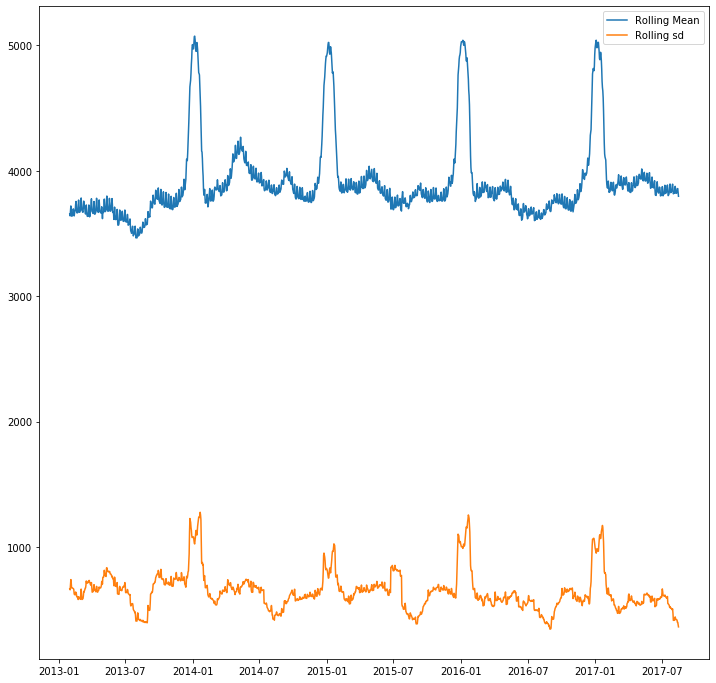

In [20]:
plt.figure(figsize=(12,12))
plt.plot(ts.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();

In [21]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -7.069388e+00
p-value                        4.982766e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.654000e+03
Critical Value (1%)           -3.434310e+00
Critical Value (5%)           -2.863289e+00
Critical Value (10%)          -2.567701e+00
dtype: float64


The Dickey-Fuller test has for null-hypothesis that the time-series is not stationary. With a p-value of 0 up to the 9th decimal we can safely reject it and conclude that **our time-series** is indeed **stationary**. Let us then proceed with the forecasting.

# Initial Analysis

  We will start by using an ARIMA model on this time series and see how successful we are. ARIMA stands for AutoRegressive Integrated Moving Average. I based my work on [**this page**](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) and [**this page**](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/), that I found quite helpful. Penn State also offers the content of its Applied Time Series Analysis [**online**](https://onlinecourses.science.psu.edu/stat510/node/33).

The ARIMA models have three parameters, corresponging to its AR, I and MA components:

- The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable.
- The number of differences (d): These are the number of non-seasonal differences.
- The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation.

We will set d to zero and not use the Integrated part of the model, effectivefly using an ARMA model. Let's start with checking for the auto-correlation of our time series, so as to understand it better and gauge what the parameters of our model should be.

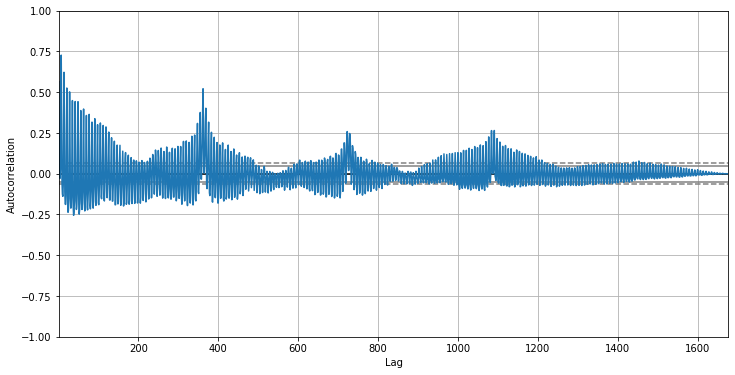

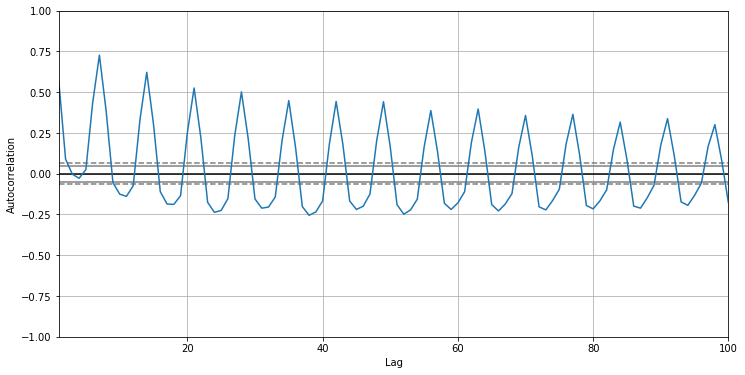

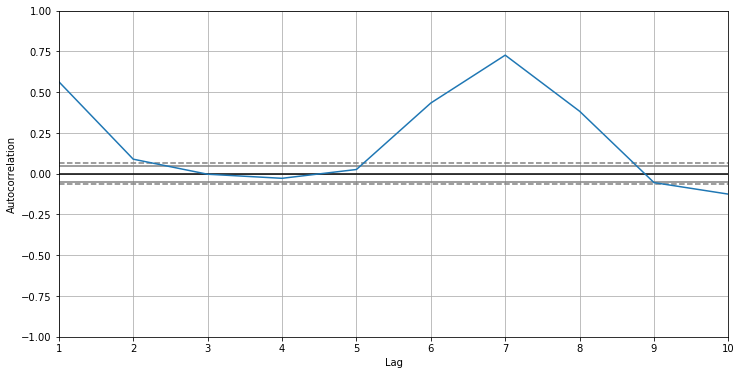

In [22]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=100);
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=10);

The highest auto-correclation peaks are every ~365 day and oscillates with a frequence of about 7 days. This corresponds with our intuitive ideas about shopping - that it is a weekly chore. Even though ecuadorians are most likely paid monthly, there is no significant periodicity visible on this scale.

From the last diagram it seems that the autocorrelation is significant (above the dashed line) for a period of maximum 2 days. All the references then suggest to use 2 for the p parameter. But the stats.model library contains a nifty tool for coefficient selection : arma_order_select_ic(). It performs a grid search with the p and q parameters. Let's see what it says for max parameters 10 and the [Baysian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for estimator:

The bic prescribes these (p,q) parameters : (10, 4)
The aic prescribes these (p,q) parameters : (10, 7)


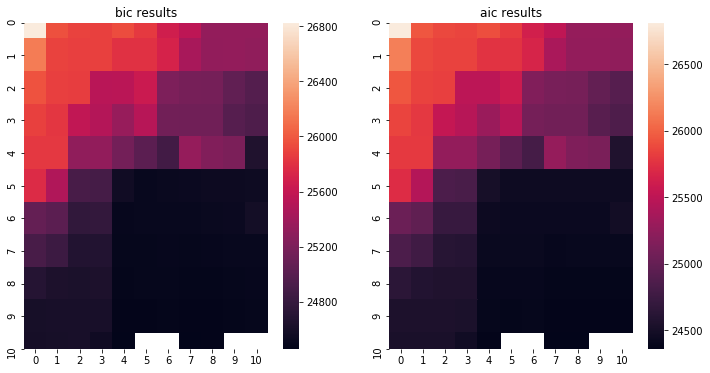

In [23]:
result = arma_order_select_ic(ts,max_ar=10, max_ma=10, ic=['aic','bic'], trend='c', fit_kw=dict(method='css',maxiter=500))
print('The bic prescribes these (p,q) parameters : {}'.format(result.bic_min_order))
print('The aic prescribes these (p,q) parameters : {}'.format(result.aic_min_order))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('bic results')
seaborn.heatmap(result.bic);
plt.subplot(1,2,2)
plt.title('aic results')
seaborn.heatmap(result.aic);

With the initial parameters, we are getting many many convergence warnings, which may show that the model does not fit well the time series. It may be important to factor out seasonality first, which we shall do in a later part of the analysis. To reduce the amount of warnings, we raised the number of iterations to a maximum of 500, in case of a very slow converging rate. We also plotted heatmaps of the results for both the aic and bic, for comparison.

  It is clear from the heatmap that we can afford to run the model with parameters (5,0,5)

,count,mean,std,min,25%,50%,75%,max
0,1672.0,-0.71735,359.768916,-2752.047552,-183.979396,-23.364385,161.803215,2586.419605


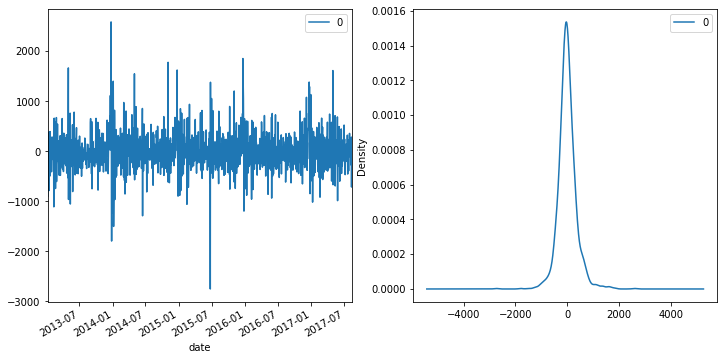

In [35]:
pdq=(5,0,5)
model = ARIMA(ts, order = pdq)
model_fit = model.fit(disp=False,method='css',maxiter=100)
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
residuals.plot(ax=axes[0])
residuals.plot(kind='kde',ax=axes[1]);
residuals.describe().T

We can check on the residuals that the model found, which will for sure contain our outlier of mid-2015. 
We can plot the residuals and their distribution. We can see that we are getting a Gaussian, centered at 0 with  a standard deviation of about 380 transactions.

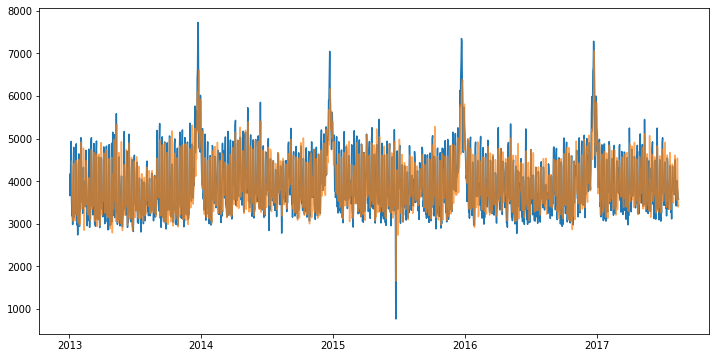

In [37]:
plt.figure(figsize=(12,6))
plt.subplot
plt.plot(ts);
plt.plot(model_fit.fittedvalues,alpha=.7);

That seems rather good. We can note that the outlier is fitted though so that is a sign we are overfitting. 

Let us carry on nonetheless and split the data into training and testing so as to see the quality of predictions it gives...

In [39]:
forecast_len=30
size = int(len(ts)-forecast_len)
train, test = ts[0:size], ts[size:len(ts)]
history = [x for x in train]
predictions = list()

print('Starting the ARIMA predictions...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order = pdq);
    model_fit = model.fit(disp=0);
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('Predictions finished.\n')
    

predictions_series = pd.Series(predictions, index = test.index)

Starting the ARIMA predictions...


Predictions finished.



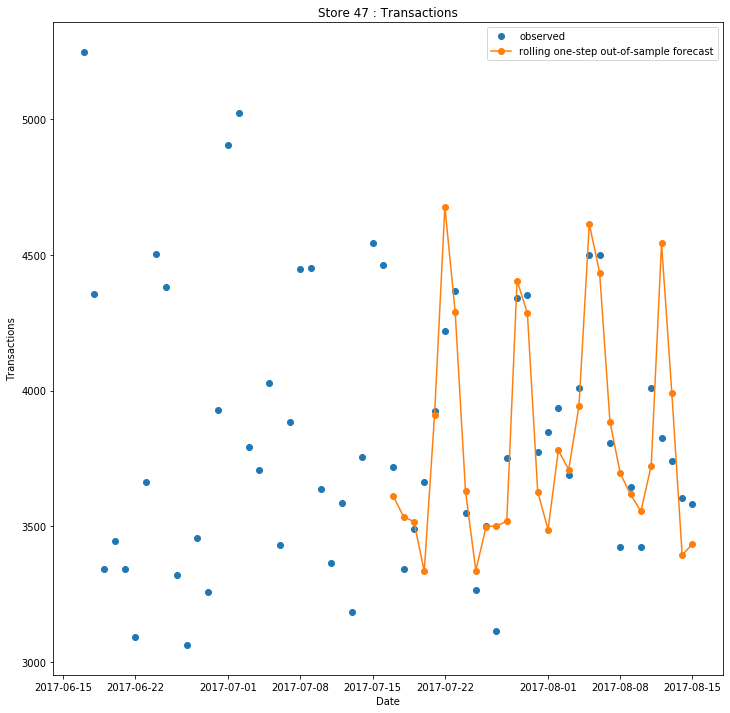

In [40]:
plt.figure(figsize=(12,12))
plt.title('Store 47 : Transactions')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.plot(ts[-2*forecast_len:], 'o', label='observed');
plt.plot(predictions_series, '-o',label='rolling one-step out-of-sample forecast');
plt.legend(loc='upper right');

The results seem rather good. Below is a histogram of the difference in predictions to see how good a forecast we made. We see that 2/3 of errors are below 200 transactions, which is about a 5% error. Not bad for a first try and a month long window.

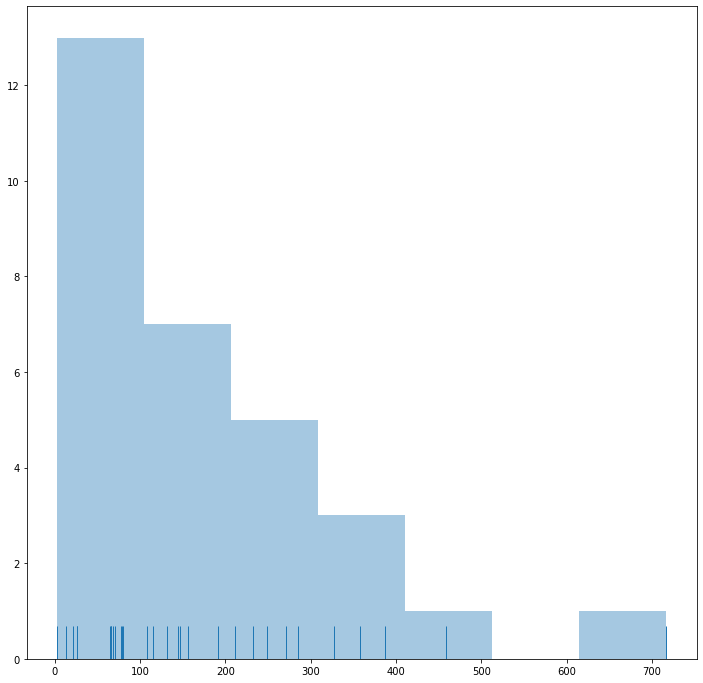

In [41]:
plt.figure(figsize=(12,12))
x=abs(ts[-forecast_len:]-predictions_series)
seaborn.distplot(x,norm_hist=False,rug=True,kde=False);

# Further Analysis

We'd like to improve our forecast and generalize it for all stores. Note that the forecast was rather long to run due to a lot of non-convergence in the model. We would like to fix that. But before diving in more complex statistical models, we may want to understand a little more the nature of the data we are manipulating and forecasting.

### Two time Series ?

The fact that holidays transactions volume is higher than the rest of the year is giving us a hint that this behavior may be more generalized. Afterall people have more time to shop when they don't work. With this data we have a solid basis to verify this assumption. Let's plot working days and days off with two different colors to see if there is a trend.
As you can see below, there is a solid horizontal trend line at ~4700 transactions for days off and at ~3400 transactions for working days, repeated year after year. This could be good news for our model. Indeed, being able to separate 'apples' from 'oranges' will remove a lot of the apparent randomness that is contained in the time series as it stands. We may want to build a proper clustering engine for our days before forecasting and split the time series so as to improve our predictive power.

In [42]:
# The function takes a store number, an integer for the rolling means window and a bool
# for whether or not to split the working days and off days
def plot_store_transactions(store_viz,n=30,split=False):
    temp=sales.loc[sales.store_nbr==store_viz].set_index('date')
    plt.figure(figsize=(12,6))
    if split:
        ax1=plt.subplot(1,2,1)
        plt.scatter(temp.loc[~temp.dayoff].index,
                    temp.loc[~temp.dayoff].transactions,label='working days')
        plt.scatter(temp.loc[temp.dayoff].index,
                    temp.loc[temp.dayoff].transactions,label='off days')
        plt.legend()
        plt.title('Daily transactions. Store {}, Type {}, Cluster {}'.format(store_viz,
                                                                        list(stores.loc[stores.store_nbr==store_viz,'type'])[0],
                                                                        list(stores.loc[stores.store_nbr==store_viz,'cluster'])[0])
                 )
        ax2=plt.subplot(1,2,2,sharey=ax1,sharex=ax1)
        plt.plot(temp.loc[~temp.dayoff,'transactions'].rolling(window=n).mean(),label='working days')
        plt.plot(temp.loc[temp.dayoff,'transactions'].rolling(window=n).mean(),label='off days')
        plt.legend()
        plt.title('Store {}: {} day rolling means'.format(store_viz,n))
        plt.setp(ax2.get_yticklabels(), visible=False)
    else:
        ax1=plt.subplot(1,2,1)
        plt.scatter(temp.index,temp.transactions)
        plt.title('Daily transactions. Store {}, Type {}, Cluster {}'.format(store_viz,
                                                                        list(stores.loc[stores.store_nbr==store_viz,'type'])[0],
                                                                        list(stores.loc[stores.store_nbr==store_viz,'cluster'])[0])
                 )
        ax2=plt.subplot(1,2,2,sharey=ax1)
        plt.plot(temp.transactions.rolling(window=n).mean())
        plt.title('Store {}: {} day rolling means'.format(store_viz,n))
        plt.setp(ax2.get_yticklabels(), visible=False)
plt.show()

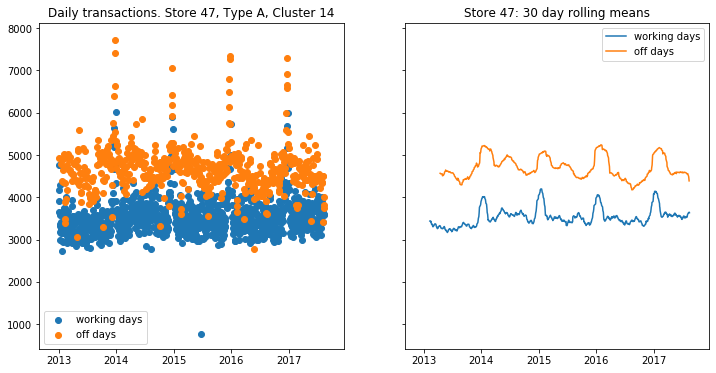

In [43]:
plot_store_transactions(47,30,True)

### Is 'type' a good classifier?
The plot for store #47 did confirm our assumption, but it would be a mistake to assume that it is therefore true for all stores.
This is the biggest chain in the country and there are therefore many stores to analyse, 54 exactly in this dataset. Are they all behaving like store #47? The company provided two different classifications of their stores without any indications of what they correspond to: type and cluster. Would they by chance correspond to patterns in the transaction volume time series? 

Let's plot them grouped by type to see if a pattern emerges or if we ought to seek our own classification. The following function creates a grid of plots for all stores of a given type.

In [44]:
def plot_store_transactions_type(typ):
    typ_stores=stores.loc[stores.type==typ,'store_nbr']
    n=len(typ_stores)
    m=1
    for x in range(1,6):
        if (n-1) in range((x-1)**2,x**2):
            m=x
    plt.figure(figsize=(15,15))
    for x in range(n):
        nbr=typ_stores.iloc[x]
        ax1 = plt.subplot(m,m,x+1)
        ax1.scatter(sales.loc[(~sales.dayoff)&(sales.store_nbr==nbr),'date'].values,
                sales.loc[(~sales.dayoff)&(sales.store_nbr==nbr),'transactions'])
        ax1.scatter(sales.loc[(sales.dayoff)&(sales.store_nbr==nbr),'date'].values,
                sales.loc[(sales.dayoff)&(sales.store_nbr==nbr),'transactions'])
        plt.title('Store {}, Type {}, Cluster {}'.format(nbr,
                                                         list(stores.loc[stores.store_nbr==nbr,'type'])[0],
                                                         list(stores.loc[stores.store_nbr==nbr,'cluster'])[0])
             )
        plt.suptitle(' Type {} stores'.format(typ),fontsize=25)
    plt.show()

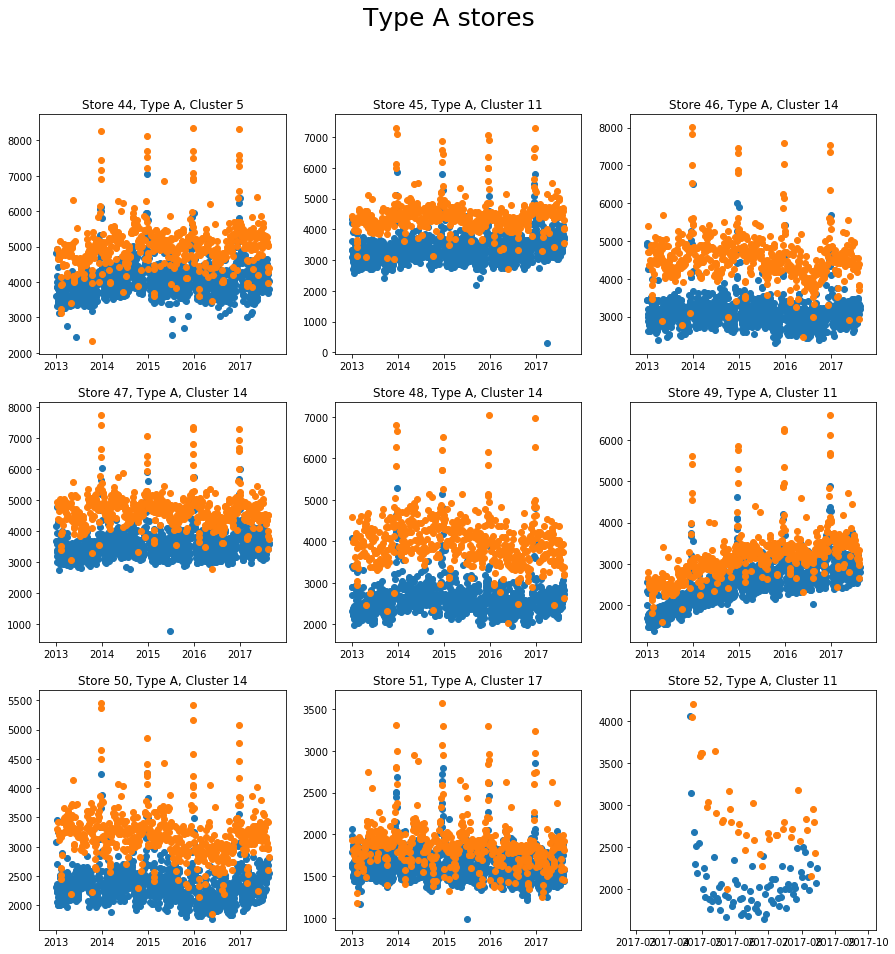

In [45]:
plot_store_transactions_type('A')

It seems that all show a similar pattern to store #47, which is part of this group. This is encouraging. Note some slight difference though: Store #49 shows a distinctive upward trend, while store #51 seems to barely have any difference between working days and off days. Store 52 is brand new and has very few data points.

Let us now see type 'B'.

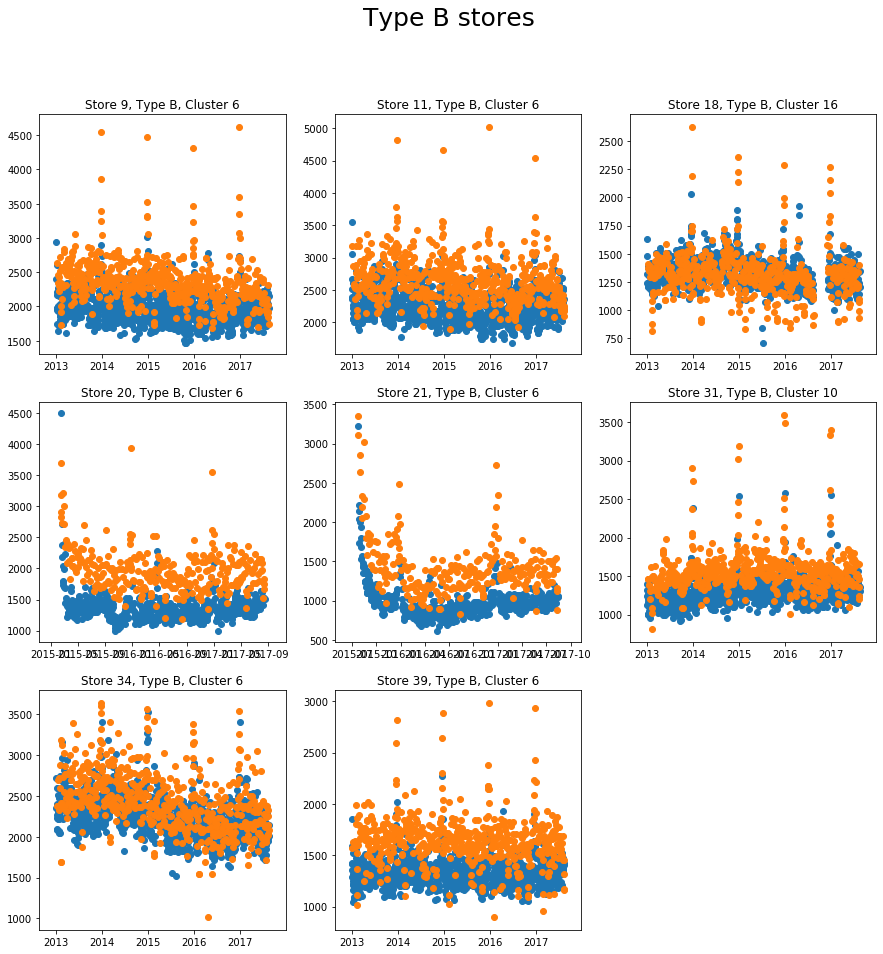

In [46]:
plot_store_transactions_type('B')

The stores with a clear difference between working days and off days are the minority here. Note that store #20 and #21 show a surge of volume at opening before stabilizing after a few months. There must have entered a market with a lack of service. Note that store #18 has a 'hole' in the data for about a 4 months late 2016. Probably some renovation.

Let's check type 'C'.

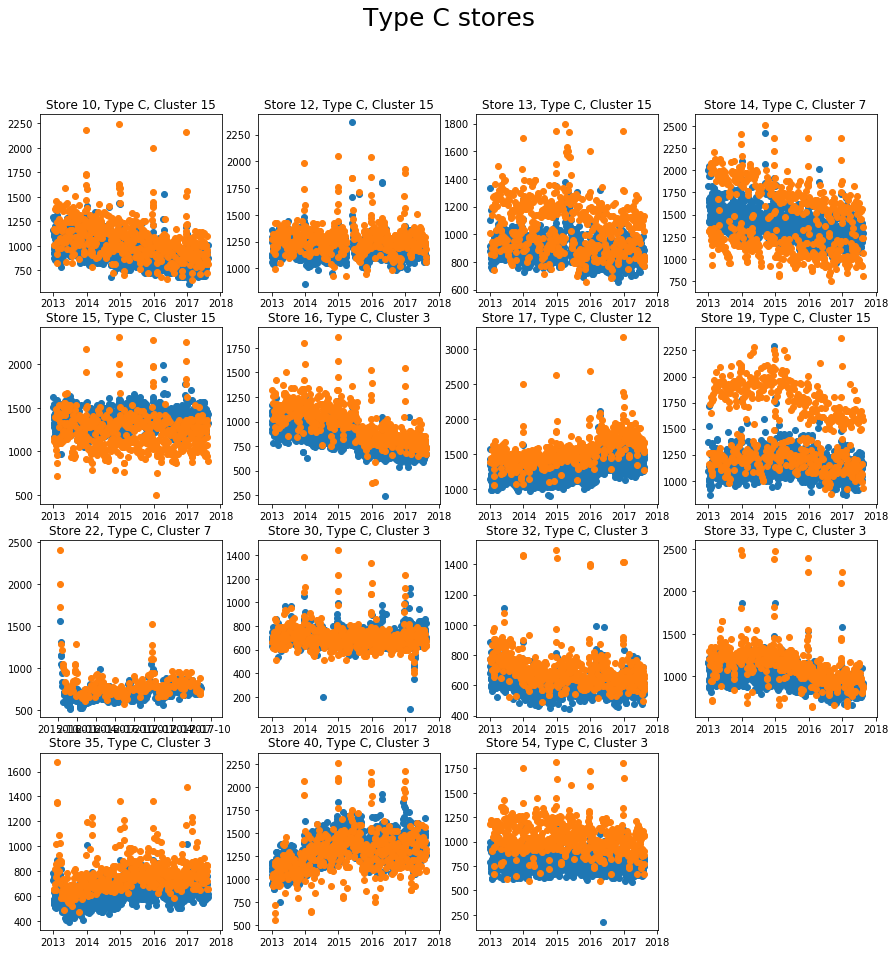

In [47]:
plot_store_transactions_type('C')

Type 'C' is even less consistant as the previous ones. Stores #13, #14 and #19 have the off days split into two distinct groups. Stores #15 and #40 have slightly less transactions on off days than working days. There must be a geographical reason for these behaviors, such as stores situatied in industrial zones. It is something worth investigating later.

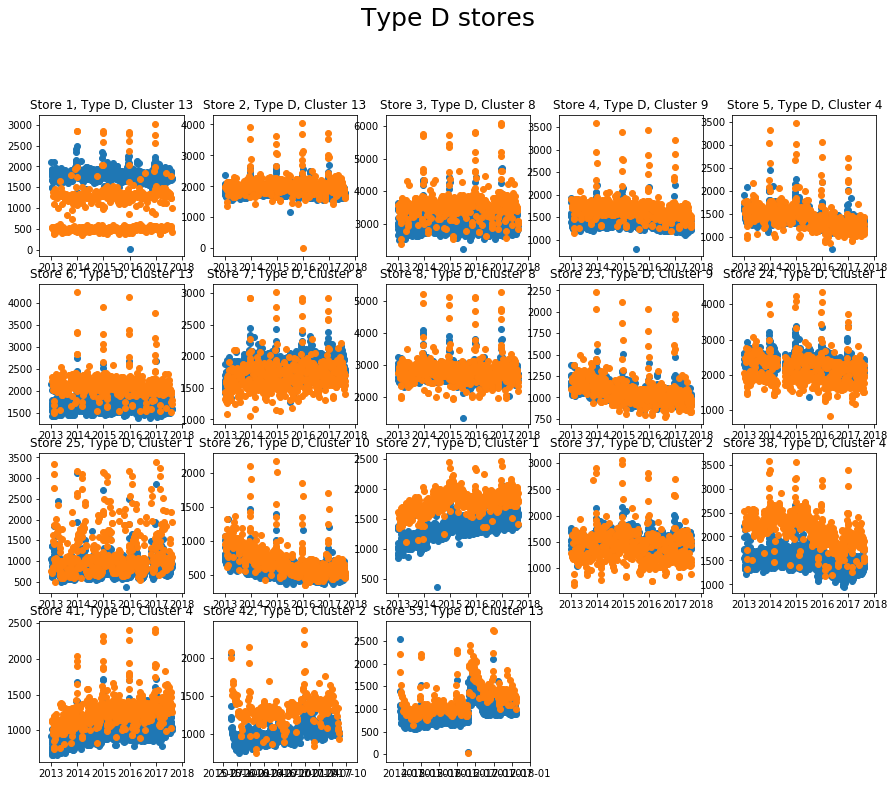

In [48]:
plot_store_transactions_type('D')

These show a mix of behaviors previously seen. Store #1 shows its off days both split and below working days. Store #24 has a 'hole' of 3 months mid 2015 while store #53 has a clear discontinuity in April 2016.
The discontinuity was explained by the company, as the consequence of the relief efforts from the population after an earthquate of magnitude 7.8 in the region.

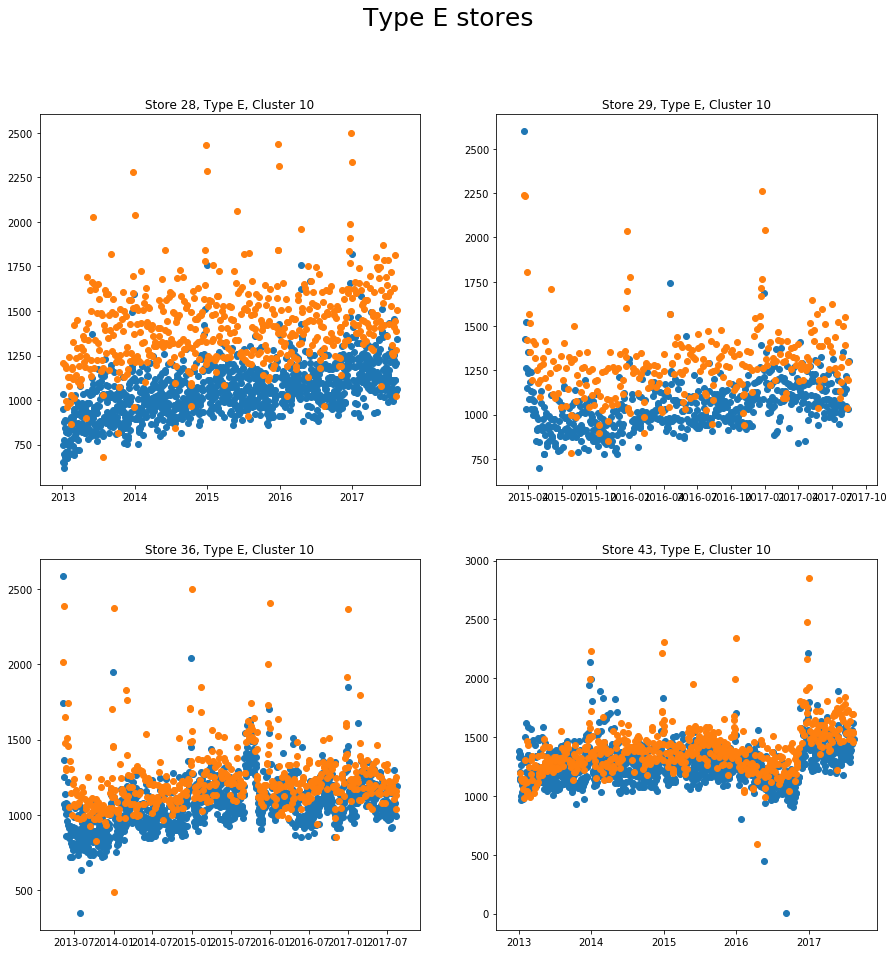

In [49]:
plot_store_transactions_type('E')

This group is a little more homogenius with common transactions volume. Note that stores #36 and #43 both have discontinuities.

## Clusters are no better 

  Another classification provided by the company is what they called 'clusters'. The function below does the same as previously but grouping by clusters.

In [50]:
def plot_store_transactions_cluster(clust):
    clust_stores=stores.loc[stores.cluster==clust,'store_nbr']
    n=len(clust_stores)
    m=1
    for x in range(1,6):
        if (n-1) in range((x-1)**2,x**2):
            m=x
    plt.figure(figsize=(15,15))
    for x in range(n):
        nbr=clust_stores.iloc[x]
        ax1 = plt.subplot(m,m,x+1)
        ax1.scatter(sales.loc[(~sales.dayoff)&(sales.cluster==clust)&(sales.store_nbr==nbr),'date'].values,
                sales.loc[(~sales.dayoff)&(sales.cluster==clust)&(sales.store_nbr==nbr),'transactions'])
        ax1.scatter(sales.loc[(sales.dayoff)&(sales.cluster==clust)&(sales.store_nbr==nbr),'date'].values,
                sales.loc[(sales.dayoff)&(sales.cluster==clust)&(sales.store_nbr==nbr),'transactions'])
        plt.title('Store {}, Type {}, Cluster {}'.format(nbr,
                                                         list(stores.loc[stores.store_nbr==nbr,'type'])[0],
                                                         list(stores.loc[stores.store_nbr==nbr,'cluster'])[0])
             )
        plt.suptitle(' Cluster {} stores'.format(clust),fontsize=25)
    plt.show()

  The gaphs below belong to stores of the cluster #13, which show 4 very different behaviors. Clusters are therefore not a good classification for forcasting models either

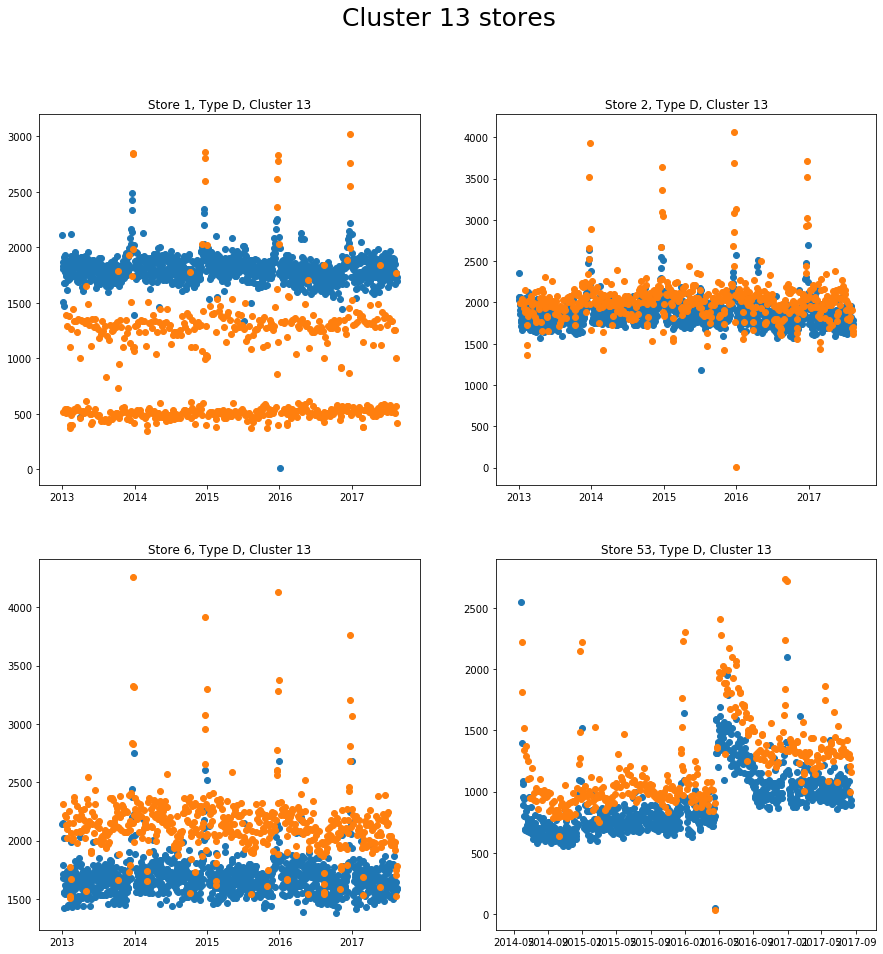

In [51]:
plot_store_transactions_cluster(13)

# Building a new classification

We saw that there are a lot of different stores in the dataset and their clients motivations to shop are very varied. It is crucial to understand that before diving deeper into statistical analysis. Getting a better classification of the stores so as to adapt the models to them will require some unsupervised learning and we will start with getting clusters with these simple features:
- Mean and standard deviation of working day transactions
- Mean and standard deviation of holiday transactions
- Mean and standard deviation of week day transactions

Let us build the table with the data:

In [52]:
#creating a table with means and std of transaction volume per type of day per store
Means1=sales.groupby(['store_nbr','dayoff']).transactions.agg(['mean','std']).unstack(level=1)

#creating a table with means and std of transaction volume per day of the week per store
Means2=sales.groupby(['store_nbr','day']).transactions.agg(['mean','std']).unstack(level=1)

# Creating a table  with the daily average of transaction volume per store 
sales_by_store=sales.groupby(['store_nbr']).transactions.sum()/sales.groupby(['store_nbr']).transactions.count()
# Creating a new columns with ratio of transactions of the day / daily average
sales['normalized']=[v/sales_by_store[s] for (s,v) in zip(sales.store_nbr,sales.transactions)]

#creating a table with means and std of normalized transaction volume per type of day per store
Means1_norm=sales.groupby(['store_nbr','dayoff']).normalized.agg(['mean','std']).unstack(level=1)
#creating a table with means and std of normalized transaction volume per day of the week per store
Means2_norm=sales.groupby(['store_nbr','day']).normalized.agg(['mean','std']).unstack(level=1)

Let us plot the new features to see if any clustering appear obvious:

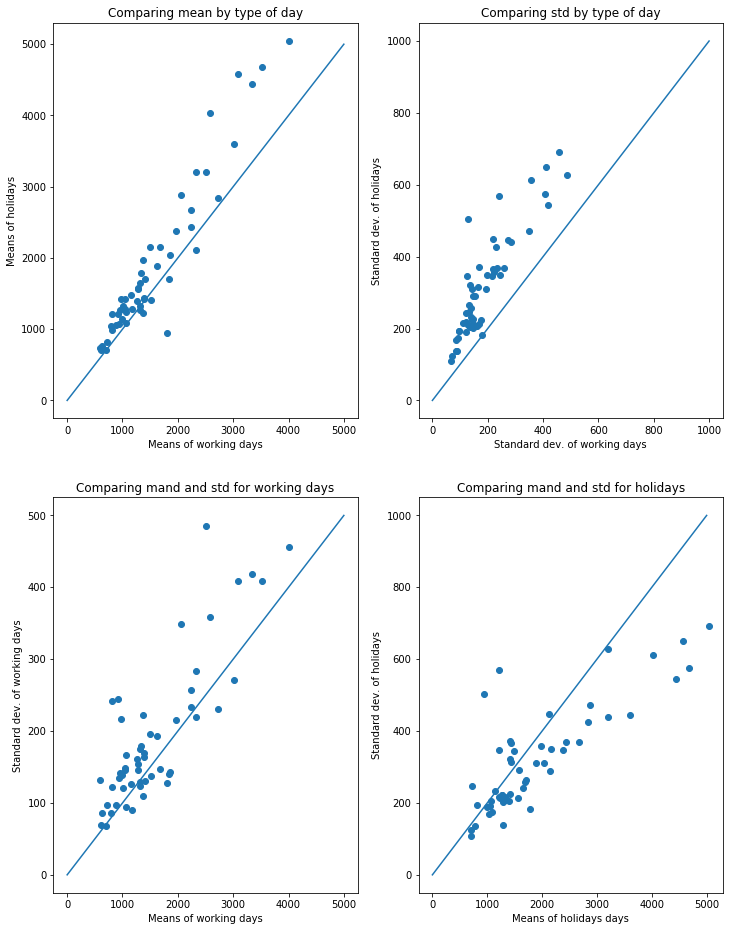

In [53]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
plt.scatter(Means1.iloc[:,0],Means1.iloc[:,1])
plt.xlabel('Means of working days')
plt.ylabel('Means of holidays')
plt.plot([0,5000],[0,5000])
plt.title('Comparing mean by type of day')
plt.subplot(2,2,2)
plt.scatter(Means1.iloc[:,2],Means1.iloc[:,3])
plt.xlabel('Standard dev. of working days')
plt.ylabel('Standard dev. of holidays')
plt.plot([0,1000],[0,1000])
plt.title('Comparing std by type of day');
plt.subplot(2,2,3)
plt.scatter(Means1.iloc[:,0],Means1.iloc[:,2])
plt.xlabel('Means of working days')
plt.ylabel('Standard dev. of working days')
plt.plot([0,5000],[0,500])
plt.title('Comparing mand and std for working days')
plt.subplot(2,2,4)
plt.scatter(Means1.iloc[:,1],Means1.iloc[:,3])
plt.xlabel('Means of holidays days')
plt.ylabel('Standard dev. of holidays')
plt.plot([0,5000],[0,1000]);
plt.title('Comparing mand and std for holidays');

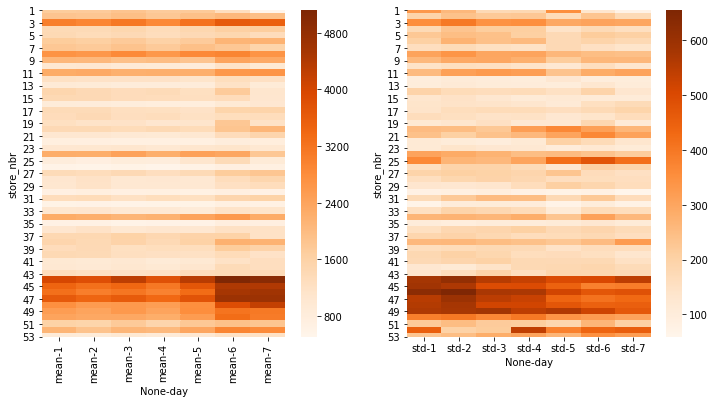

In [54]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
seaborn.heatmap(Means2.iloc[:,0:7],cmap='Oranges');
plt.subplot(1,2,2)
seaborn.heatmap(Means2.iloc[:,7:14],cmap='Oranges');

The plots don't show any obvious clustering, though the heatmaps seems to have some patterns in them. But due to difference in average tansactions volume, stores that follow a similar pattern but are of different size may not be similar at all with the raw data. Let's look at the normalized data now:

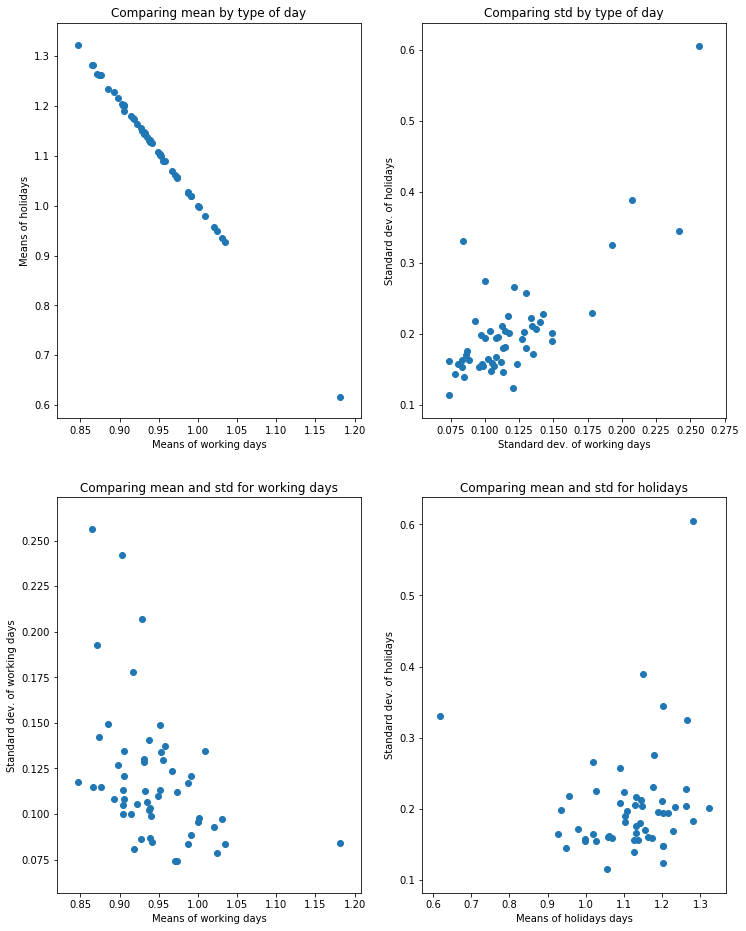

In [55]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
plt.scatter(Means1_norm.iloc[:,0],Means1_norm.iloc[:,1])
plt.xlabel('Means of working days')
plt.ylabel('Means of holidays')
plt.title('Comparing mean by type of day')
plt.subplot(2,2,2)
plt.scatter(Means1_norm.iloc[:,2],Means1_norm.iloc[:,3])
plt.xlabel('Standard dev. of working days')
plt.ylabel('Standard dev. of holidays')
plt.title('Comparing std by type of day');
plt.subplot(2,2,3)
plt.scatter(Means1_norm.iloc[:,0],Means1_norm.iloc[:,2])
plt.xlabel('Means of working days')
plt.ylabel('Standard dev. of working days')
plt.title('Comparing mean and std for working days')
plt.subplot(2,2,4)
plt.scatter(Means1_norm.iloc[:,1],Means1_norm.iloc[:,3])
plt.xlabel('Means of holidays days')
plt.ylabel('Standard dev. of holidays')
plt.title('Comparing mean and std for holidays');

Note that the fact that the means are linearly correlated should be obvious the slope should correspond to the ratio of days off / working days. It gives us a very simple clustering of the stores, there is the one in the bottom right and the rest. We expect that lonely store to be store #1. Let us check the heatmaps now.

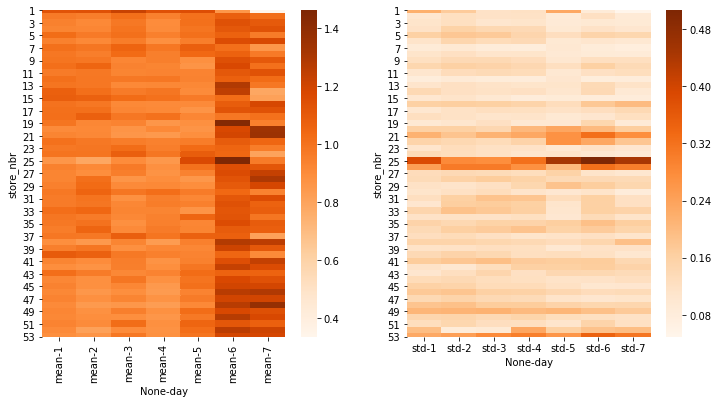

In [56]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
seaborn.heatmap(Means2_norm.iloc[:,0:7],cmap='Oranges');
plt.subplot(1,2,2)
seaborn.heatmap(Means2_norm.iloc[:,7:14],cmap='Oranges');

### Hierarchical clustering
Some real patterns appear now, such as the very distinct standard deviation pattern of stores #25 and  #26, as well as the highlighted Saturday shopping frenzy at store 19 and 25. This is a good starting point to train a ML algorithm for clustering.

  We will run a hierachical clustering machine based on the AgglomerativeClustering algorithm from the sklearn library. But that means we need to decide how many clusters we want to see. Instead of counting by hand the number if patterns we can see in the 54 stores, we can use the ward clustering and dendogram features of the scipy library to get an idea of how many clusters we may want:

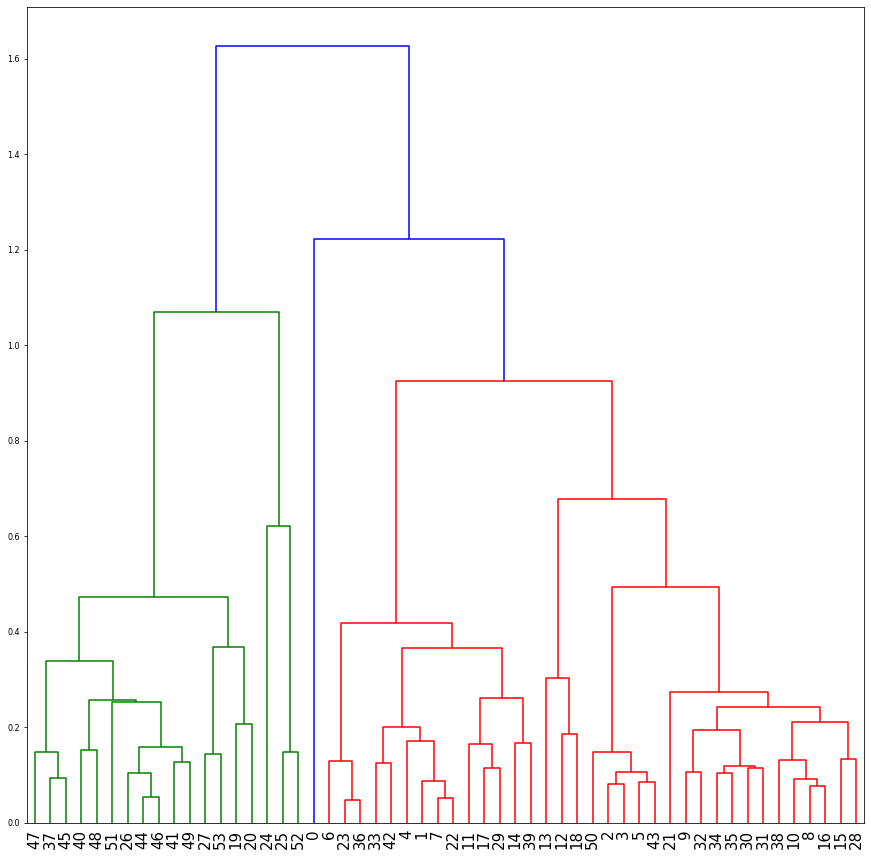

In [57]:
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
dendrogram(ward(Means2_norm),ax=ax)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.show()

It seems that 5 clusters would be a good number. Note that the ward clustering is different from the agglomerative clustering, so we don't have to take exactly 5. We decided to pick 6 clusters.

In [58]:
clustering=AggClust(n_clusters=6)
cluster=clustering.fit_predict(Means2_norm)
stores['new_cluster']=cluster

def plot_store_transactions_new_cluster(clust):
    clust_stores=stores.loc[stores['new_cluster']==clust,'store_nbr']
    n=len(clust_stores)
    m=1
    for x in range(1,10):
        if (n-1) in range((abs(x-1))**2,x**2):
            m=x
    plt.figure(figsize=(15,15))
    for x in range(n):
        nbr=clust_stores.iloc[x]
        ax1 = plt.subplot(m,m,x+1)
        ax1.scatter(sales.loc[(~sales.dayoff)&(sales.store_nbr==nbr),'date'].values,
                sales.loc[(~sales.dayoff)&(sales.store_nbr==nbr),'transactions'])
        ax1.scatter(sales.loc[(sales.dayoff)&(sales.store_nbr==nbr),'date'].values,
                sales.loc[(sales.dayoff)&(sales.store_nbr==nbr),'transactions'])
        plt.title('Store {}, Type {}, Cluster {}'.format(nbr,
                                                         list(stores.loc[stores.store_nbr==nbr,'type'])[0],
                                                         list(stores.loc[stores.store_nbr==nbr,'cluster'])[0])
             )
    plt.show()

In [ ]:
plot_store_transactions_new_cluster(1)

This group is very homogenous. It seems to be stores with very little difference between the days of the week and apart from store #16, with a constant mean. Judging by this group, the clustering seems quite good. Let's check the second cluster.

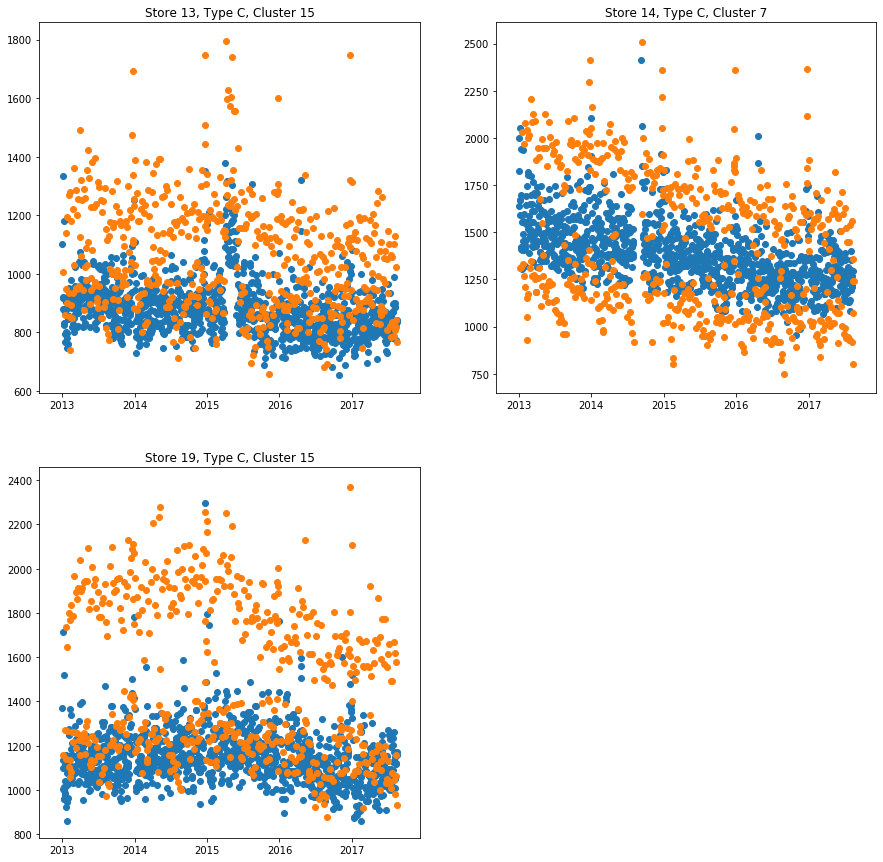

In [60]:
plot_store_transactions_new_cluster(2)

This again is a very homogenous cluster, with a Saturdays and Sundays showing very diferent volumes of transactions.

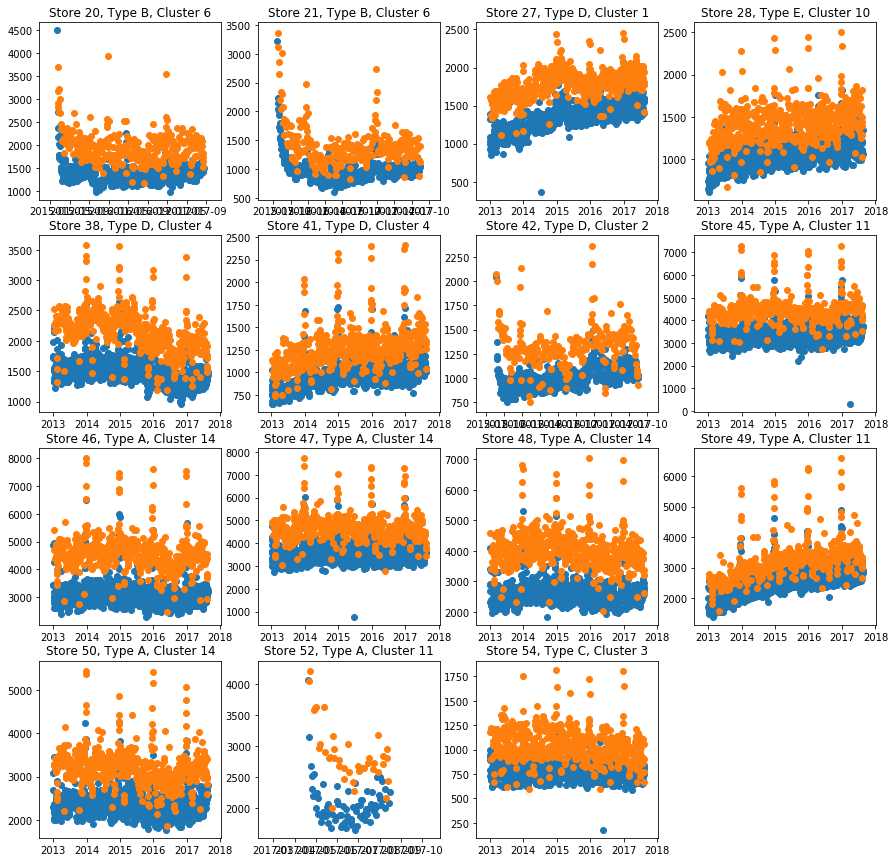

In [61]:
plot_store_transactions_new_cluster(3)

This group is again very homogenous, with volumes of sales on days off distinctively higher than on working days. You are welcome to explore the remaining 3 groups on your own. Group 4 is a group where there is absolutely no difference between the days of the week and Group 5 contains Store 1 alone, where sales during weekends are way below weekday levels.